#### Link To The Video:
#### https://www.youtube.com/watch?v=hvLFD4AZzCw&list=PLyMom0n-MBroupZiLfVSZqK5asX8KfoHL&index=3

### Initialization

In [19]:
# Import necessary libraries for building and training a neural network using the PyTorch framework
import copy                       # For creating deep and shallow copies of Python objects
import torch.nn as nn             # Neural network module in PyTorch
import torch.nn.functional as F   # Contains various functions for building neural networks
import torch                      # Provides functions and classes for working with tensors and neural networks
import PIL                        # Provides functions for working with images in Python
import numpy as np                # Provides functions for working with numerical arrays in Python

# Import the MNIST dataset
from torch.utils.data import DataLoader, random_split  # For loading and iterating over datasets in PyTorch, and splitting a dataset into training and validation subsets
from torchvision.datasets import MNIST                 # PyTorch dataset class that provides access to the MNIST dataset
from torchvision import transforms

import matplotlib.pyplot as plt


In [20]:
# Load the MNIST dataset and split it into training and validation subsets
dataset = MNIST(root='../../data/', download=True)
train_ds_, validation_ds_ = random_split(dataset, [50000, 10000])

# Convert the image and label data to PyTorch tensors and store them in separate lists for the training and validation subsets
train_ds = [(torch.tensor(np.asarray(image_data)).to(torch.float32), (torch.tensor(label)).to(torch.int64)) for image_data, label in train_ds_]
validation_ds = [(torch.tensor(np.asarray(image_data)).to(torch.float32), (torch.tensor(label)).to(torch.int64)) for image_data, label in validation_ds_]

# Create data loaders for iterating over the training and validation subsets in batches
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
validation_loader = DataLoader(validation_ds, batch_size)


### Definitions & Model

In [21]:
# Define a function to calculate accuracy
def accuracy(outputs, labels):

    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class MnistModel(nn.Module):

    VALIDATION_STEP_OUTPUT_TEMPLATE = {"loss": None, "accuracy": None}

    def __init__(self, in_features, out_features):

        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.loss_fn = F.cross_entropy

    def forward(self, xb: torch.Tensor):
        xb = xb.reshape(-1, 784)  # We request the other dimension to be calculated by pytorch
        return self.linear(xb)
    
    def training_step(self, batch: list[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        
        images, labels = batch
        outputs = self(images)
        return self.loss_fn(outputs, labels)
    
    def validation_step(self, batch: list[torch.Tensor, torch.Tensor]) -> dict:

        images, labels = batch
        outputs = self(images)
        t_loss = self.loss_fn(outputs, labels)
        t_accuracy = accuracy(outputs, labels)
        
        output_template = copy.copy(MnistModel.VALIDATION_STEP_OUTPUT_TEMPLATE)
        output_template["loss"] = t_loss
        output_template["accuracy"] = t_accuracy
        return output_template
    
    def validation_epoch_end(self, validation_step_outputs: dict):

        batch_losses = [result["loss"] for result in validation_step_outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accuracies = [result["accuracy"] for result in validation_step_outputs]
        epoch_accuracy = torch.stack(batch_accuracies).mean()  # Combine accuracies
        
        output_template = copy.copy(MnistModel.VALIDATION_STEP_OUTPUT_TEMPLATE)
        output_template["loss"] = epoch_loss.item()  # Get value using ".item()"
        output_template["accuracy"] = epoch_accuracy.item()
        return output_template
    
    def print_result(self, epoch, result):

        print(f"Epoch [{epoch+1}], loss: {result['loss']:.4f}, accuracy: {result['accuracy']:.4f}")


### Training The Model

In [23]:
# Define a function to calculate accuracy
def evaluate(model, validation_loader):

    outputs = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_epoch_end(outputs)

In [24]:
def fit(epochs, lr, model, train_loader, validation_loader, optimizer_function=torch.optim.SGD):

    optimizer = optimizer_function(model.parameters(), lr)
    history = []  # To record what happens during the training.

    for epoch in range(epochs):

        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()       # Parameter update.
            optimizer.zero_grad()  # Reset gradients.

        # Validation phase
        result = evaluate(model, validation_loader)
        model.print_result(epoch, result)
        history.append(result)

    return history

In [25]:
model = MnistModel(28*28, 10)

In [26]:
evaluate(model, validation_loader)

{'loss': 84.28312683105469, 'accuracy': 0.04736946150660515}

In [78]:
fit(500, .000001, model, train_loader, validation_loader);

Epoch [1], loss: 0.9149, accuracy: 0.8839
Epoch [2], loss: 0.9143, accuracy: 0.8835
Epoch [3], loss: 0.9150, accuracy: 0.8824
Epoch [4], loss: 0.9148, accuracy: 0.8824
Epoch [5], loss: 0.9136, accuracy: 0.8836
Epoch [6], loss: 0.9124, accuracy: 0.8847
Epoch [7], loss: 0.9118, accuracy: 0.8838
Epoch [8], loss: 0.9112, accuracy: 0.8837
Epoch [9], loss: 0.9104, accuracy: 0.8835
Epoch [10], loss: 0.9126, accuracy: 0.8831
Epoch [11], loss: 0.9099, accuracy: 0.8834
Epoch [12], loss: 0.9093, accuracy: 0.8836
Epoch [13], loss: 0.9089, accuracy: 0.8836
Epoch [14], loss: 0.9084, accuracy: 0.8830
Epoch [15], loss: 0.9082, accuracy: 0.8831
Epoch [16], loss: 0.9088, accuracy: 0.8828
Epoch [17], loss: 0.9075, accuracy: 0.8828
Epoch [18], loss: 0.9081, accuracy: 0.8824
Epoch [19], loss: 0.9073, accuracy: 0.8827
Epoch [20], loss: 0.9055, accuracy: 0.8843
Epoch [21], loss: 0.9067, accuracy: 0.8825
Epoch [22], loss: 0.9048, accuracy: 0.8829
Epoch [23], loss: 0.9032, accuracy: 0.8831
Epoch [24], loss: 0.

### Testing

In [36]:
def predict(image, model):

    xb = image.unsqueeze(0)
    yb = model(xb)
    _, predictions = torch.max(yb, dim=1)
    return predictions[0].item()

Prediction: 3


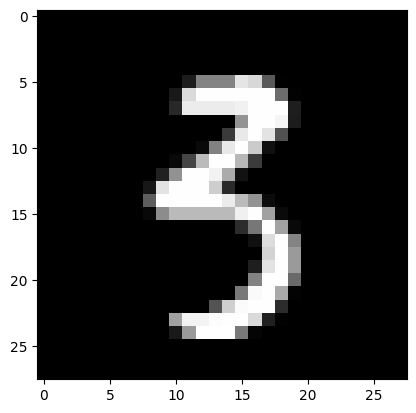

In [97]:
# Load the MNIST dataset for testing
# dataset = MNIST(root='../../data/', download=True, train=False, transform=transforms.ToTensor())

image_ = PIL.Image.open("/home/lyonbach/Documents/seven.jpg")

# image, label = torch.tensor(np.asarray(image_, dtype=float)[:, :, 1]/255).to(torch.float32), 8
image, label = dataset[2008]

plt.imshow(image[0], cmap="gray")
prediction = predict(image, model)
print(f"Prediction: {prediction}")

### Saving The Model State

In [90]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0134, -0.0132,  0.0112,  ...,  0.0331,  0.0217,  0.0257],
                      [ 0.0095, -0.0005,  0.0298,  ...,  0.0339, -0.0116,  0.0052],
                      [ 0.0093,  0.0126, -0.0224,  ...,  0.0193, -0.0173, -0.0297],
                      ...,
                      [ 0.0097, -0.0178, -0.0014,  ...,  0.0160, -0.0349, -0.0164],
                      [ 0.0250, -0.0054, -0.0213,  ...,  0.0175, -0.0281,  0.0219],
                      [-0.0300,  0.0346,  0.0228,  ..., -0.0124, -0.0174, -0.0221]])),
             ('linear.bias',
              tensor([ 0.0312,  0.0274, -0.0111,  0.0353, -0.0122,  0.0172,  0.0310,  0.0199,
                      -0.0151, -0.0347]))])